<a href="https://colab.research.google.com/github/mikulicmateo/StockPrediction/blob/main/MultioutputModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import numpy as np
import json
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, BatchNormalization
from keras.layers.core import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
from matplotlib import pyplot
from datetime import datetime
import tensorflow as tf

In [120]:

def calculate_typical_price(row):
    typical_price = (row[1] + row[2] + row[3])/3
    return typical_price

In [121]:
with open("/content/drive/MyDrive/dataset-amd.json") as json_file:
    dataset = json.loads(json_file.read())

In [122]:
num_given_days = 60
num_predicted_days = 30
data_per_day = 8

seq_len_x = num_given_days * data_per_day
seq_stride_x = data_per_day
seq_len_y = num_predicted_days
seq_stride_y = 1

In [123]:
def make_y(data):
  new_data = []
  for i in range(len(data)):
    if i % data_per_day != 0:
      continue
    new_data.append(calculate_typical_price(data[i:i+data_per_day]))
  return new_data

In [124]:
def normalize(val, min_val, max_val):
  return (val - min_val) / (max_val - min_val)

In [125]:
def normalize_vals(arr):
  
  arr[0]= normalize(arr[0], open_minmax[0], open_minmax[1])
  arr[1]= normalize(arr[1], high_minmax[0], high_minmax[1])
  arr[2]= normalize(arr[2], low_minmax[0], low_minmax[1])
  arr[3]= normalize(arr[3], close_minmax[0], close_minmax[1])
  arr[4]= normalize(arr[4], volume_minmax[0], volume_minmax[1])
  arr[5]= normalize(arr[5], rsi_minmax[0], rsi_minmax[1])
  arr[6]= normalize(arr[6], sma_minmax[0], sma_minmax[1])
  arr[7]= normalize(arr[7], ema_minmax[0], ema_minmax[1])

  return arr

In [126]:
def update_minmax(curr_vals, update_val):
  if len(curr_vals) == 0:
    curr_vals = [update_val, update_val]
  if update_val < curr_vals[0]:
    curr_vals[0] = update_val
  elif update_val > curr_vals[1]:
    curr_vals[1] = update_val
  return curr_vals

In [127]:
open_minmax = []
high_minmax = []
low_minmax = []
close_minmax = []
volume_minmax = []
rsi_minmax = []
sma_minmax = []
ema_minmax = []

def update_minmax_vals(open, high, low, close, volume, rsi, sma, ema):
  global open_minmax 
  global high_minmax 
  global low_minmax 
  global close_minmax
  global volume_minmax
  global rsi_minmax 
  global sma_minmax 
  global ema_minmax
  
  open_minmax = update_minmax(open_minmax, open)
  high_minmax = update_minmax(high_minmax, high)
  low_minmax = update_minmax(low_minmax, low)
  close_minmax = update_minmax(close_minmax, close)
  volume_minmax = update_minmax(volume_minmax, volume)
  rsi_minmax = update_minmax(rsi_minmax, rsi)
  sma_minmax = update_minmax(sma_minmax, sma)
  ema_minmax = update_minmax(ema_minmax, ema)


In [128]:
def initialize_normalization_vals(dataset):
  for j in dataset.keys():
    for i in dataset[j]:
      date_string = i.get('date')
      if date_string < "2018-01-01":
          update_minmax_vals(float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema')))

In [129]:
def normalize_x_dataset(x_dataset):
  new_x_dataset = []
  for i in range(len(x_dataset)):
    if i % data_per_day != 0:
      continue
    new_x_dataset = new_x_dataset + normalize_vals(x_dataset[i:i+data_per_day])
  return new_x_dataset

In [130]:
ds_train_x = None
ds_train_y = None

ds_valid_x = None
ds_valid_y = None

ds_test_x = None
ds_test_y = None

def load_from_d(dataset):
  global ds_train_x
  global ds_train_y
  global ds_valid_x
  global ds_valid_y
  global ds_test_x   
  global ds_test_y
  initialize_normalization_vals(dataset)
  for j in dataset.keys():
    data_train = []
    data_valid = []
    data_test = []
    for i in dataset[j]:
      date_string = i.get('date')
      if date_string < "2018-01-01":
          data_train = data_train + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])
          
      elif date_string < "2020-01-01":
          data_valid = data_valid + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])
      else:
          data_test = data_test + ([float(i.get('open')), float(i.get('high')), float(i.get('low')), float(i.get('close')), \
              float(i.get('volume')), float(i.get('rsi')), float(i.get('sma')), float(i.get('ema'))])
          
    if len(data_train) >= seq_len_x:
      
      target_train = make_y(data_train)

      data_train = normalize_x_dataset(data_train)

      x_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_train,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_train)-(data_per_day * num_predicted_days)
      )

      y_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_train,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if len(data_valid) >= seq_len_x:

      target_valid = make_y(data_valid)

      data_valid = normalize_x_dataset(data_valid)

      x_valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_valid,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_valid)-(data_per_day * num_predicted_days)
      )

      y_valid_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_valid,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if len(data_test) >= seq_len_x:

      target_test = make_y(data_test)

      data_test = normalize_x_dataset(data_test)

      x_test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          data_test,
          None,
          sequence_length=seq_len_x,
          sequence_stride=seq_stride_x,
          sampling_rate=1,
          batch_size=None,
          end_index=len(data_test)-(data_per_day * num_predicted_days)
      )

      y_test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
          target_test,
          None,
          sequence_length=seq_len_y,
          sequence_stride=seq_stride_y,
          sampling_rate=1,
          batch_size=None,
          start_index=num_given_days,
      )

    if not ds_train_x:
      ds_train_x = x_train_dataset
      ds_train_y = y_train_dataset
      ds_valid_x = x_valid_dataset
      ds_valid_y = y_valid_dataset
      ds_test_x = x_test_dataset
      ds_test_y = y_test_dataset
    else:
      ds_train_x = ds_train_x.concatenate(x_train_dataset)
      ds_train_y = ds_train_y.concatenate(y_train_dataset)
      ds_valid_x = ds_valid_x.concatenate(x_valid_dataset)
      ds_valid_y = ds_valid_y.concatenate(y_valid_dataset)
      ds_test_x = ds_test_x.concatenate(x_test_dataset)
      ds_test_y = ds_test_y.concatenate(y_test_dataset)

In [131]:
load_from_d(dataset)

In [132]:
def create_model():
  l_model = Sequential()
  l_model.add(Input(480))
#  l_model.add(Dense(960, activation="relu"))
#  l_model.add(Dense(480, activation="softplus"))
  l_model.add(Dense(240, activation="relu"))
  l_model.add(Dense(120, activation="softplus"))
#  l_model.add(Dropout(0.5))
  l_model.add(Dense(60, activation="linear"))
  l_model.add(Dense(30, activation="softplus"))
  l_model.compile(Adam(learning_rate=0.001), loss="msle", metrics=["mse", "mae", "msle"])
  return l_model

In [133]:
ds_train = tf.data.Dataset.zip((ds_train_x , ds_train_y)).batch(32)

In [134]:
ds_valid = tf.data.Dataset.zip((ds_valid_x, ds_valid_y)).batch(32)

In [135]:
for x,y in ds_valid:
  print(x.shape)
  print(y.shape)
  break
 

(32, 480)
(32, 30)


In [136]:
for x,y in ds_train:
  print(x.shape)
  print(y.shape)
  break

(32, 480)
(32, 30)


In [137]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.000001)

In [138]:
model = create_model()
model.summary()
history = model.fit(ds_train, validation_data=ds_valid, epochs=50, verbose=1, shuffle=True, callbacks=[learning_rate_reduction])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 240)               115440    
                                                                 
 dense_13 (Dense)            (None, 120)               28920     
                                                                 
 dense_14 (Dense)            (None, 60)                7260      
                                                                 
 dense_15 (Dense)            (None, 30)                1830      
                                                                 
Total params: 153,450
Trainable params: 153,450
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
140/140 [==============================] - 2s 8ms/step - loss: 0.2987 - mse: 58.4146 - mae: 4.4558 - msle: 0.2987 - val_loss: 0.3238 - val_mse: 252.3263 - val_mae: 15.03

In [139]:
results = model.evaluate(ds_valid)
print(results)

13/13 [==============================] - 0s 6ms/step - loss: 0.0095 - mse: 5.5650 - mae: 1.6719 - msle: 0.0095
[0.009458763524889946, 5.565021991729736, 1.67193603515625, 0.009458763524889946]


In [140]:
ds_test_xx = ds_test_x.batch(32)
for x in ds_test_xx:
  print(x.shape)
  break

(32, 480)


In [141]:
predictions = model.predict(ds_test_xx)
print(predictions)

[[176.93922  178.62914  178.33899  ... 180.38885  180.3306   178.02129 ]
 [176.05135  177.67445  177.28397  ... 178.54599  178.40875  176.06343 ]
 [174.81627  176.40308  175.84438  ... 175.90495  175.79004  173.3181  ]
 ...
 [ 55.929756  56.256718  55.50238  ...  50.859474  50.65043   49.695072]
 [ 56.32449   56.619736  55.84757  ...  50.945423  50.765846  49.790276]
 [ 56.64347   56.89872   56.11933  ...  50.93008   50.785847  49.79598 ]]


In [142]:
ds_test_yy = ds_test_y.batch(32)

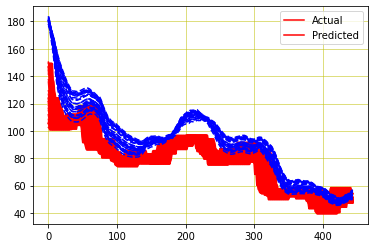

In [143]:
pyplot.plot(list(ds_test_y), linestyle='solid', color='r')
pyplot.plot(predictions, linestyle='dashed', color='b')
pyplot.legend(['Actual','Predicted'], loc='best')
pyplot.grid(color = 'y', linewidth='0.5')
pyplot.show()

In [144]:
print(len(list(ds_test_y)))
print(len(predictions))

445
445


# Testing timeseries_dataset_functions

In [145]:
test_functions_dataset = []
ds_train_x_testing = None
ds_train_y_testing = None

def test_dataset_making(testing_dataset):

   global ds_train_x_testing
   global ds_train_y_testing
   print(len(testing_dataset))
   if len(testing_dataset) >= seq_len_x:
     
     target_train = make_y(testing_dataset)

     x_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
         testing_dataset,
         None,
         sequence_length=seq_len_x,
         sequence_stride=seq_stride_x,
         sampling_rate=1,
         batch_size=None,
         end_index=len(testing_dataset)-(data_per_day * num_predicted_days)
     )

     y_train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
         target_train,
         None,
         sequence_length=seq_len_y,
         sequence_stride=seq_stride_y,
         sampling_rate=1,
         batch_size=None,
         start_index=num_given_days,
     )

   if not ds_train_x_testing:
     ds_train_x_testing = x_train_dataset
     ds_train_y_testing = y_train_dataset
   else:
     ds_train_x_testing = ds_train_x_testing.concatenate(x_train_dataset)
     ds_train_y_testing = ds_train_y_testing.concatenate(y_train_dataset)

In [146]:
for i in range(900):
  test_functions_dataset = test_functions_dataset + [1, 2, 1, 1, 1000, 50, 50, 50]

test_dataset_making(test_functions_dataset)

7200


In [147]:
ds_testing = tf.data.Dataset.zip((ds_train_x_testing,ds_train_y_testing)).batch(1)

In [148]:
for x,y in ds_testing:
  print(x)
  print(y)
  print("_____________________________________________")

Streaming output truncated to the last 5000 lines.
  1000   50   50   50    1    2    1    1 1000   50   50   50    1    2
     1    1 1000   50   50   50    1    2    1    1 1000   50   50   50
     1    2    1    1 1000   50   50   50    1    2    1    1 1000   50
    50   50    1    2    1    1 1000   50   50   50    1    2    1    1
  1000   50   50   50]], shape=(1, 480), dtype=int32)
tf.Tensor(
[[1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334 1.3333334
  1.3333334 1.3333334]], shape=(1, 30), dtype=float32)
_____________________________________________
tf.Tensor(
[[   1    2    1    1 1000   50   50   50    1    2    1    1 1000   50
    50   50    1    2    1    1 1000   50   50   50    1    2    1    1
  1000   50   50   50    1    2    1    1 1000   50 